In [9]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns


sns.set_theme(style="whitegrid", palette="muted")
plt.rcParams.update({"figure.figsize": (14, 5), "axes.titlesize": 13})
pd.set_option("display.max_columns", 40)
pd.set_option("display.float_format", "{:,.1f}".format)
print("imports done yay")

imports done yay


# This is eda for the datasests

In [10]:
DATA_DIR = os.path.join(os.path.dirname(os.getcwd()), "data")
if not os.path.isdir(DATA_DIR):
    DATA_DIR = os.path.join(os.getcwd(), "data")

def p(fname):
    return os.path.join(DATA_DIR, fname)

def load_csv(fname):
    path = p(fname)
    df = pd.read_csv(path, low_memory=False)

    if len(df) > 0 and str(df.iloc[0, 0]).startswith("#"):
        df = df.iloc[1:].reset_index(drop=True)
    return df

In [11]:
hno_2024 = load_csv("hpc_hno_2024.csv")
hno_2025 = load_csv("hpc_hno_2025.csv")
hno_2026 = load_csv("hpc_hno_2026.csv")

for yr, df in [(2024, hno_2024), (2025, hno_2025), (2026, hno_2026)]:
    df.columns = df.columns.str.strip()
    df.rename(columns={"Country ISO3": "country_iso3"}, inplace=True)
    df["year"] = yr

fts_req = load_csv("fts_requirements_funding_global.csv")
fts_req.columns = fts_req.columns.str.strip()
fts_req.rename(columns={"countryCode": "country_iso3", "requirements": "req_usd", "funding": "funded_usd", "percentFunded": "pct_funded","name": "plan_name", "year": "year"}, inplace=True)
for c in ["req_usd", "funded_usd", "pct_funded"]:
    fts_req[c] = pd.to_numeric(fts_req[c], errors="coerce")

fts_cluster = load_csv("fts_requirements_funding_cluster_global.csv")
fts_cluster.columns = fts_cluster.columns.str.strip()
fts_cluster.rename(columns={"countryCode": "country_iso3", "cluster": "cluster_name","requirements": "cluster_req_usd", "funding": "cluster_funded_usd","percentFunded": "cluster_pct_funded", "year": "year"}, inplace=True)
for c in ["cluster_req_usd", "cluster_funded_usd", "cluster_pct_funded"]:
    fts_cluster[c] = pd.to_numeric(fts_cluster[c], errors="coerce")

fts_gcluster = load_csv("fts_requirements_funding_globalcluster_global.csv")
fts_gcluster.columns = fts_gcluster.columns.str.strip()
fts_gcluster.rename(columns={"countryCode": "country_iso3", "cluster": "cluster_name","requirements": "req_usd", "funding": "funded_usd","percentFunded": "pct_funded", "year": "year"}, inplace=True)

fts_in  = load_csv("fts_incoming_funding_global.csv")
fts_out = load_csv("fts_outgoing_funding_global.csv")
fts_int = load_csv("fts_internal_funding_global.csv")
for df in [fts_in, fts_out, fts_int]:
    df.columns = df.columns.str.strip()
    df["amountUSD"] = pd.to_numeric(df["amountUSD"], errors="coerce")

pop = load_csv("cod_population_admin0.csv")
pop.columns = pop.columns.str.strip()
pop.rename(columns={"ISO3": "country_iso3"}, inplace=True)
pop["Population"] = pd.to_numeric(pop["Population"], errors="coerce")
pop_total = (pop[pop["Population_group"] == "T_TL"].groupby("country_iso3", as_index=False)["Population"].sum())

hrp = load_csv("humanitarian-response-plans.csv")
hrp.columns = hrp.columns.str.strip()
hrp.rename(columns={"origRequirements": "orig_req_usd", "revisedRequirements": "revised_req_usd", "planVersion": "plan_name"}, inplace=True)
hrp["orig_rieq_usd"]     = pd.to_numeric(hrp["orig_req_usd"], errors="coerce")
hrp["revised_req_usd"]  = pd.to_numeric(hrp["revised_req_usd"], errors="coerce")

print("Bronze loaded:")
print(f"  hno_2024: {hno_2024.shape}  hno_2025: {hno_2025.shape}  hno_2026: {hno_2026.shape}")
print(f"  fts_req:  {fts_req.shape}  fts_cluster: {fts_cluster.shape}")
print(f"  fts_in:   {fts_in.shape}  fts_out: {fts_out.shape}  fts_int: {fts_int.shape}")
print(f"  pop:      {pop_total.shape}  hrp: {hrp.shape}")


Bronze loaded:
  hno_2024: (387819, 17)  hno_2025: (318259, 17)  hno_2026: (134, 11)
  fts_req:  (3669, 12)  fts_cluster: (7891, 12)
  fts_in:   (4947, 37)  fts_out: (1050, 37)  fts_int: (14, 37)
  pop:      (139, 2)  hrp: (910, 11)


---
## Section 1 - Exploratory Data Analysis
### 1.1 People in Need (PIN) — HNO Multi-Year


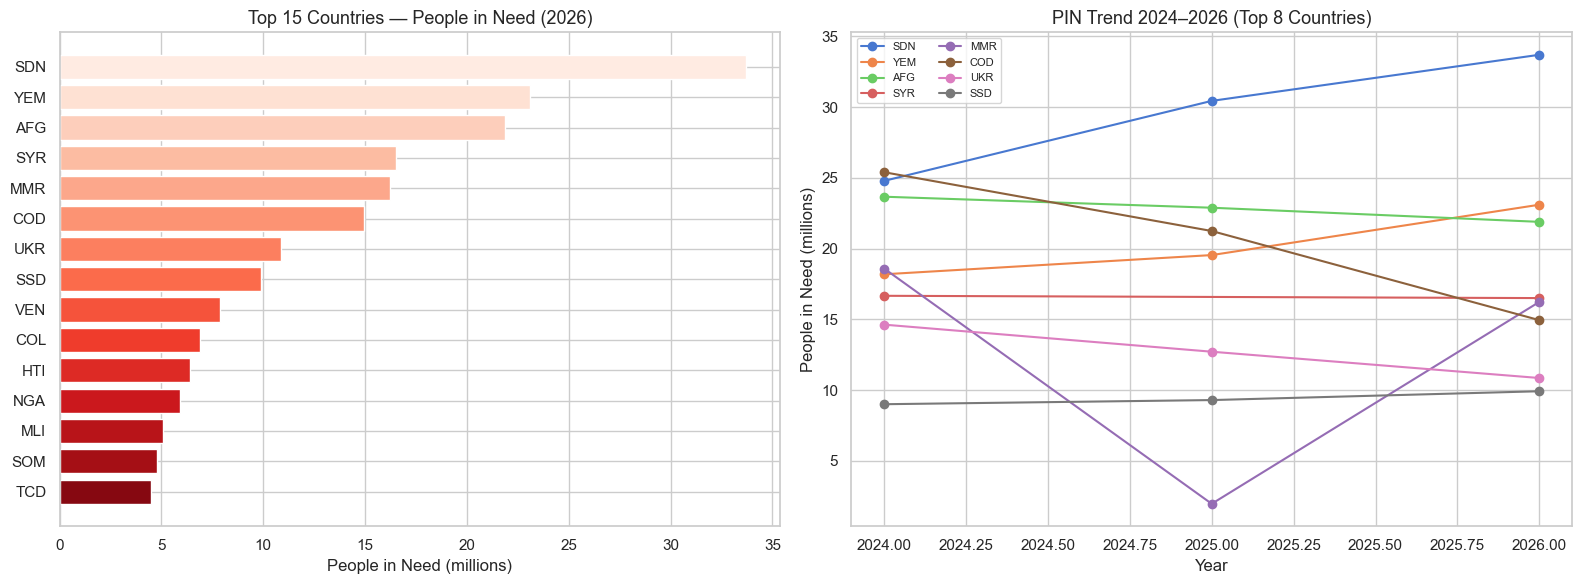


Total countries with PIN data (2026): 20
Total global PIN (2026): 203.2 million


In [ ]:

def extract_country_pin(df, year):
    col_map = {}
    for c in df.columns:
        cl = c.lower().replace(" ", "_")
        if "in_need" in cl or c == "In Need":
            col_map[c] = "pin"
        if "cluster" in cl:
            col_map[c] = "cluster"
        if "category" in cl:
            col_map[c] = "category"
    sub = df.rename(columns=col_map).copy()
    sub["year"] = year
    mask = (sub.get("cluster", pd.Series(dtype=str)).astype(str).str.upper() == "ALL") & (sub.get("category", pd.Series(dtype=str)).astype(str).isin(["nan", "", "None"]))
    sub = sub[mask][["country_iso3", "year", "pin"]].copy()
    sub["pin"] = pd.to_numeric(sub["pin"], errors="coerce")
    return sub.dropna(subset=["pin"])

pin_df = pd.concat([extract_country_pin(hno_2024, 2024),extract_country_pin(hno_2025, 2025),extract_country_pin(hno_2026, 2026),], ignore_index=True)
pin_df.sort_values(["country_iso3", "year"], inplace=True)

top15 = (pin_df[pin_df.year == 2026].sort_values("pin", ascending=False).head(15))

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].barh(top15["country_iso3"][::-1], top15["pin"][::-1] / 1e6, color=sns.color_palette("Reds_r", 15))
axes[0].set_xlabel("People in Need (millions)")
axes[0].set_title("Top 15 Countries — People in Need (2026)")

top8 = top15["country_iso3"].head(8).tolist()
trend = pin_df[pin_df["country_iso3"].isin(top8)]
for iso in top8:
    sub = trend[trend["country_iso3"] == iso].sort_values("year")
    if len(sub) > 1:
        axes[1].plot(sub["year"], sub["pin"] / 1e6, marker="o", label=iso)
axes[1].set_title("PIN Trend 2024–2026 (Top 8 Countries)")
axes[1].set_xlabel("Year"); axes[1].set_ylabel("People in Need (millions)")
axes[1].legend(ncol=2, fontsize=8)

plt.tight_layout()
plt.show()
print(f"\nTotal countries with PIN data (2026): {len(pin_df[pin_df.year==2026])}")
print(f"Total global PIN (2026): {pin_df[pin_df.year==2026]['pin'].sum()/1e6:.1f} million")


### 1.2 Cluster-Level Needs Distribution (2026)


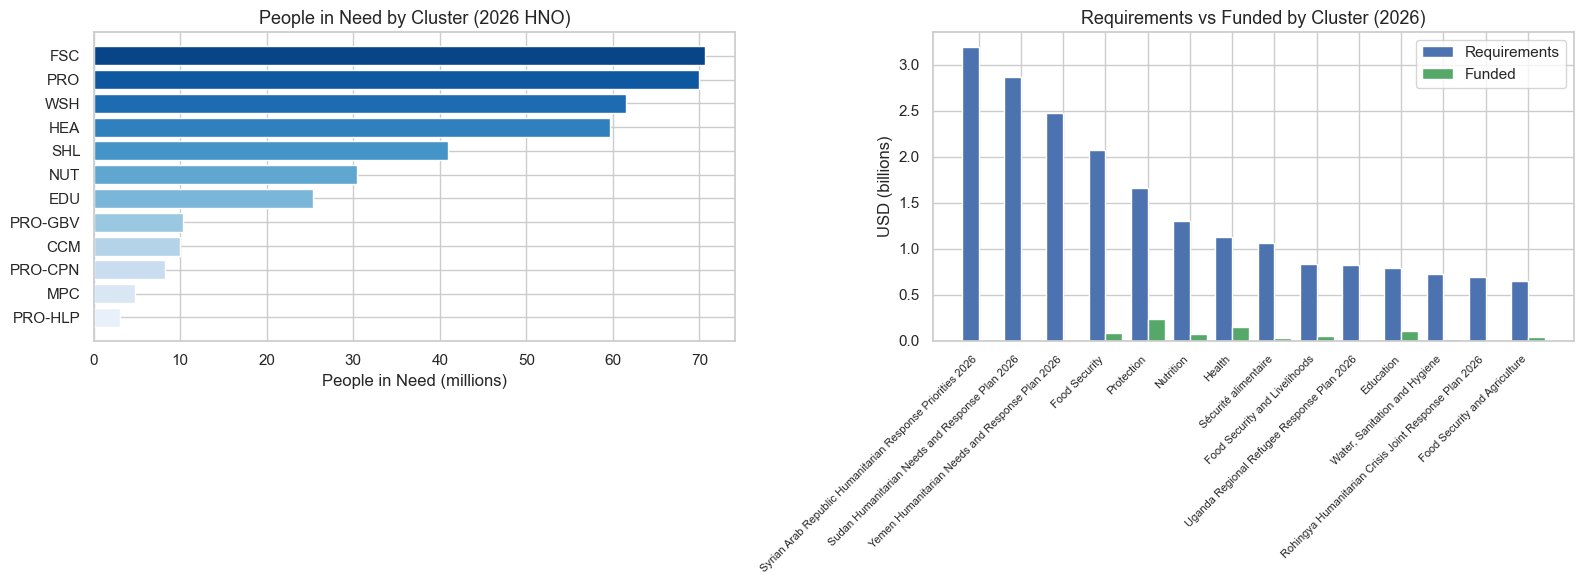

In [13]:
hno26 = hno_2026.copy()
hno26.columns = hno26.columns.str.strip()
hno26.rename(columns={"Country ISO3": "country_iso3","Cluster": "cluster", "In Need": "pin"}, inplace=True)
hno26["pin"] = pd.to_numeric(hno26["pin"], errors="coerce")

cluster_pin = (hno26[(hno26["cluster"].notna()) & (hno26["cluster"].str.upper() != "ALL") & (hno26["cluster"].str.strip() != "")].groupby("cluster")["pin"].sum().sort_values(ascending=False).head(12))

cluster_gap = (fts_cluster[fts_cluster["year"].astype(str) == "2026"].groupby("cluster_name")[["cluster_req_usd", "cluster_funded_usd"]].sum().assign(gap_usd=lambda d: d["cluster_req_usd"] - d["cluster_funded_usd"]).sort_values("cluster_req_usd", ascending=False).head(14))

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

colors = sns.color_palette("Blues_r", len(cluster_pin))
axes[0].barh(cluster_pin.index[::-1], cluster_pin.values[::-1] / 1e6, color=colors[::-1])
axes[0].set_xlabel("People in Need (millions)")
axes[0].set_title("People in Need by Cluster (2026 HNO)")

x = range(len(cluster_gap))
w = 0.4
axes[1].bar([i - w/2 for i in x], cluster_gap["cluster_req_usd"] / 1e9, width=w,label="Requirements", color="#4C72B0")
axes[1].bar([i + w/2 for i in x], cluster_gap["cluster_funded_usd"].fillna(0) / 1e9, width=w,label="Funded", color="#55A868")
axes[1].set_xticks(list(x))
axes[1].set_xticklabels(cluster_gap.index, rotation=45, ha="right", fontsize=8)
axes[1].set_ylabel("USD (billions)")
axes[1].set_title("Requirements vs Funded by Cluster (2026)")
axes[1].legend()

plt.tight_layout()
plt.show()


### 1.3 Global Funding Requirements vs Received (multi-year)


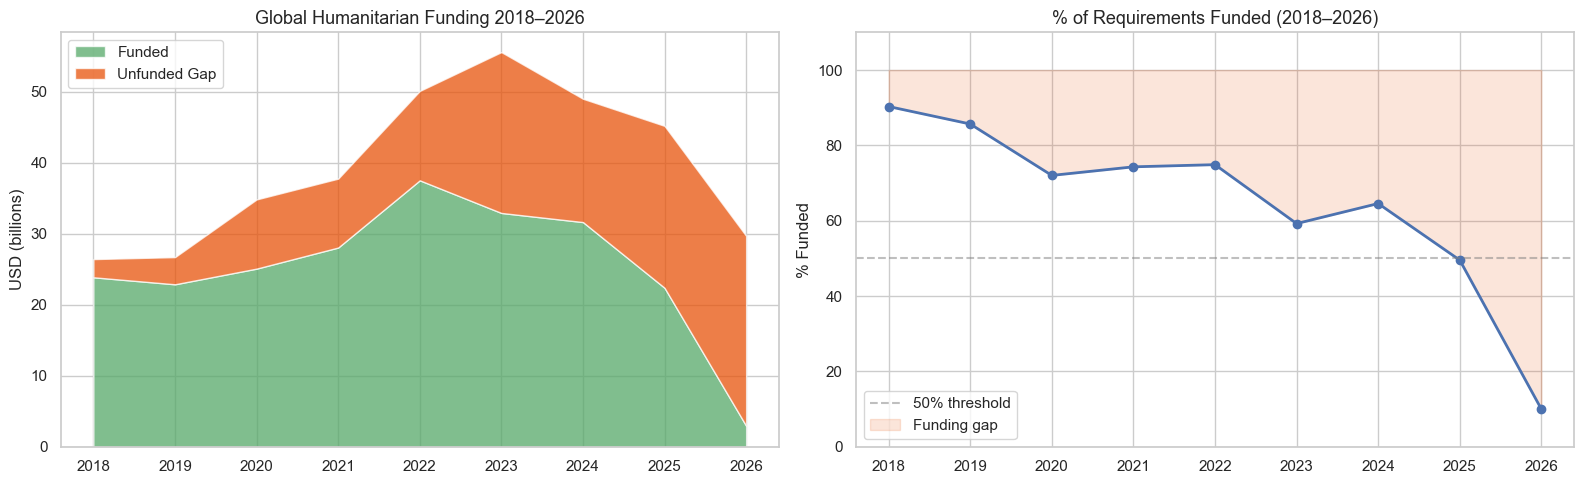

 year          req_usd       funded_usd  pct_funded
 2018 26,428,634,978.0 23,868,109,600.0        90.3
 2019 26,708,350,809.0 22,881,100,143.0        85.7
 2020 34,830,170,059.0 25,086,730,843.0        72.0
 2021 37,757,844,380.0 28,056,043,800.0        74.3
 2022 50,104,012,930.0 37,518,373,847.0        74.9
 2023 55,573,712,572.0 32,925,294,649.0        59.2
 2024 49,005,529,121.0 31,640,191,791.0        64.6
 2025 45,188,001,803.0 22,389,722,522.0        49.5
 2026 29,710,526,594.0  2,971,361,789.0        10.0


In [14]:

fts_req["year"] = pd.to_numeric(fts_req["year"], errors="coerce")
annual = (fts_req[fts_req["year"].between(2018, 2026)].groupby("year")[["req_usd", "funded_usd"]].sum().reset_index())
annual["gap_usd"]  = annual["req_usd"] - annual["funded_usd"]
annual["pct_funded"] = annual["funded_usd"] / annual["req_usd"] * 100

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

axes[0].stackplot(annual["year"],annual["funded_usd"] / 1e9, annual["gap_usd"] / 1e9, labels=["Funded", "Unfunded Gap"], colors=["#55A868", "#E8530A"], alpha=0.75)
axes[0].set_title("Global Humanitarian Funding 2018–2026")
axes[0].set_ylabel("USD (billions)")
axes[0].legend(loc="upper left")
axes[0].xaxis.set_major_locator(mticker.MultipleLocator(1))

axes[1].plot(annual["year"], annual["pct_funded"], "o-", color="#4C72B0", linewidth=2)
axes[1].axhline(50, ls="--", color="grey", alpha=0.5, label="50% threshold")
axes[1].fill_between(annual["year"], annual["pct_funded"], 100, alpha=0.15, color="#E8530A", label="Funding gap")
axes[1].set_title("% of Requirements Funded (2018–2026)")
axes[1].set_ylabel("% Funded")
axes[1].set_ylim(0, 110)
axes[1].legend()
axes[1].xaxis.set_major_locator(mticker.MultipleLocator(1))

plt.tight_layout()
plt.show()
print(annual[["year", "req_usd", "funded_usd", "pct_funded"]].to_string(index=False))


### 1.4 FTS Funding Flows — Donor & CBPF Analysis


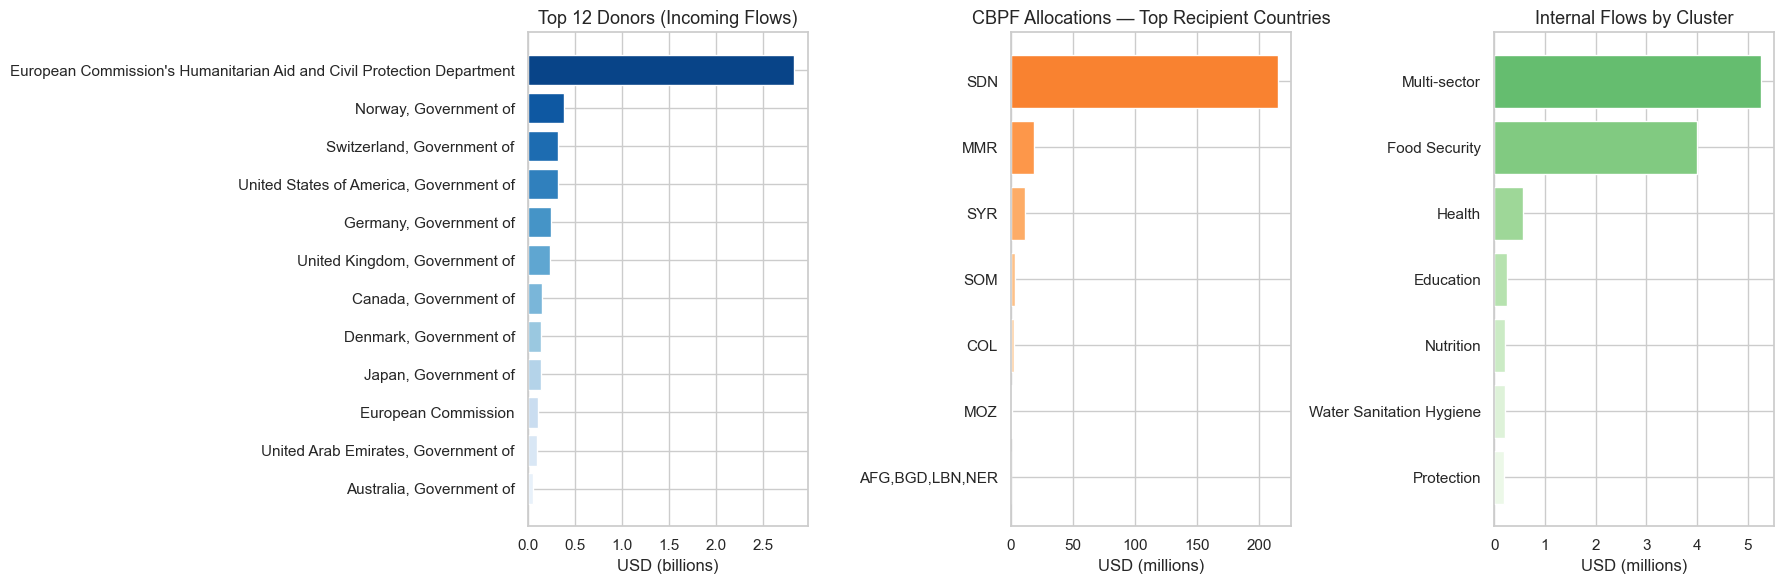


Total CBPF outgoing (all time): $0.27 billion
Unique CBPF recipient countries: 7


In [15]:
top_donors = (fts_in.dropna(subset=["srcOrganization"]).groupby("srcOrganization")["amountUSD"].sum().sort_values(ascending=False).head(12))

cbpf_out = fts_out[fts_out["destOrganizationTypes"].astype(str).str.contains("Pooled Fund", na=False)]
cbpf_by_country = (cbpf_out.groupby("destLocations")["amountUSD"].sum().sort_values(ascending=False).head(12))

cluster_flows = (fts_int.dropna(subset=["destGlobalClusters"]).assign(cluster=fts_int["destGlobalClusters"].str.split(",")).explode("cluster").assign(cluster=lambda d: d["cluster"].str.strip()).groupby("cluster")["amountUSD"].sum().sort_values(ascending=False).head(12))

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].barh(top_donors.index[::-1], top_donors.values[::-1] / 1e9, color=sns.color_palette("Blues_r", 12)[::-1])
axes[0].set_xlabel("USD (billions)")
axes[0].set_title("Top 12 Donors (Incoming Flows)")

axes[1].barh(cbpf_by_country.index[::-1], cbpf_by_country.values[::-1] / 1e6,color=sns.color_palette("Oranges_r", 12)[::-1])
axes[1].set_xlabel("USD (millions)")
axes[1].set_title("CBPF Allocations — Top Recipient Countries")

axes[2].barh(cluster_flows.index[::-1], cluster_flows.values[::-1] / 1e6, color=sns.color_palette("Greens_r", 12)[::-1])
axes[2].set_xlabel("USD (millions)")
axes[2].set_title("Internal Flows by Cluster")

plt.tight_layout()
plt.show()

print(f"\nTotal CBPF outgoing (all time): ${cbpf_out['amountUSD'].sum()/1e9:.2f} billion")
print(f"Unique CBPF recipient countries: {cbpf_out['destLocations'].nunique()}")


---
##  Sec 2 — Silver Layer: Data Cleaning & Joins


In [16]:
hno26_clean = (hno_2026.assign(cluster=hno_2026.get("Cluster", hno_2026.get("cluster", "")),pin=pd.to_numeric(hno_2026.get("In Need", hno_2026.get("in_need", np.nan)), errors="coerce"),targeted=pd.to_numeric(hno_2026.get("Targeted", np.nan), errors="coerce"),).rename(columns={"Country ISO3": "country_iso3"}))
silver_severity = (hno26_clean[hno26_clean["cluster"].astype(str).str.upper() == "ALL"][["country_iso3", "pin", "targeted"]].dropna(subset=["pin"]).drop_duplicates("country_iso3"))
silver_severity["year"] = 2026


silver_hrp = fts_cluster.copy()
silver_hrp = silver_hrp.dropna(subset=["country_iso3", "cluster_name"])
silver_hrp["year"] = pd.to_numeric(silver_hrp["year"], errors="coerce")

silver_cbpf = cbpf_out.copy()
silver_cbpf.rename(columns={"destLocations": "country_iso3","amountUSD": "cbpf_alloc_usd","date": "alloc_date"}, inplace=True)
silver_cbpf["country_iso3"] = silver_cbpf["country_iso3"].str.strip()

silver_cbpf = (silver_cbpf.assign(country_iso3=silver_cbpf["country_iso3"].str.split(",")).explode("country_iso3").assign(country_iso3=lambda d: d["country_iso3"].str.strip()))
silver_cbpf["alloc_date"] = pd.to_datetime(silver_cbpf["alloc_date"], errors="coerce")

cbpf_by_iso = (silver_cbpf.groupby("country_iso3")["cbpf_alloc_usd"].sum().reset_index().rename(columns={"cbpf_alloc_usd": "cbpf_total_usd"}))

silver_pop = pop_total.copy()

print("Silver tables:")
print(f"  silver_severity:  {silver_severity.shape}")
print(f"  silver_hrp:       {silver_hrp.shape}")
print(f"  silver_cbpf:      {silver_cbpf.shape}")
print(f"  silver_pop:       {silver_pop.shape}")


Silver tables:
  silver_severity:  (20, 4)
  silver_hrp:       (7890, 12)
  silver_cbpf:      (29, 37)
  silver_pop:       (139, 2)


---
## Sec 3 — Gold Layer: FGI · BBR · CMI Metrics


In [17]:

fts_req["year"] = pd.to_numeric(fts_req["year"], errors="coerce")

latest = (fts_req.dropna(subset=["req_usd", "funded_usd"]).query("req_usd > 0").sort_values("year", ascending=False).drop_duplicates("country_iso3"))

gold_fgi = latest[["country_iso3", "year", "plan_name", "req_usd", "funded_usd"]].copy()
gold_fgi["fgi_score"] = ((gold_fgi["req_usd"] - gold_fgi["funded_usd"])
      / gold_fgi["req_usd"] * 100).clip(0, 100)

gold_fgi = gold_fgi.merge(cbpf_by_iso, on="country_iso3", how="left")
gold_fgi["cbpf_total_usd"] = gold_fgi["cbpf_total_usd"].fillna(0)
gold_fgi["cbpf_share"] = (gold_fgi["cbpf_total_usd"] /
       gold_fgi["funded_usd"].replace(0, np.nan)).fillna(0).clip(0, 1)

gold_fgi["cmi_score"] = gold_fgi["fgi_score"] * (1 - gold_fgi["cbpf_share"])

gold_fgi = gold_fgi.merge(silver_severity[["country_iso3", "pin"]], on="country_iso3", how="left")

gold_fgi = gold_fgi.merge(silver_pop, on="country_iso3", how="left")

def severity(fgi):
    if fgi >= 86:  return "CRITICAL"
    if fgi >= 61:  return "HIGH"
    if fgi >= 31:  return "MEDIUM"
    return "LOW"

gold_fgi["anomaly_severity"] = gold_fgi["fgi_score"].apply(severity)

gold_fgi.sort_values("fgi_score", ascending=False, inplace=True)
gold_fgi.reset_index(drop=True, inplace=True)

print(f"gold.funding_gap_index rows: {len(gold_fgi)}")
print(f"\nFGI severity distribution:")
print(gold_fgi["anomaly_severity"].value_counts().to_string())
print(f"\nTop 10 most underfunded countries (FGI):")
cols = ["country_iso3", "year", "fgi_score", "cmi_score", "req_usd",
        "funded_usd", "cbpf_total_usd", "pin", "anomaly_severity"]
print(gold_fgi[cols].head(10).to_string(index=False))


gold.funding_gap_index rows: 103

FGI severity distribution:
anomaly_severity
CRITICAL    54
HIGH        21
LOW         15
MEDIUM      13

Top 10 most underfunded countries (FGI):
country_iso3  year  fgi_score  cmi_score       req_usd  funded_usd  cbpf_total_usd  pin anomaly_severity
         CHL  2026       99.6       99.6  45,685,835.0   181,687.0             0.0  NaN         CRITICAL
         TTO  2026       98.8       98.8   5,712,000.0    65,881.0             0.0  NaN         CRITICAL
         BGD  2026       98.8       98.8 698,375,266.0 8,239,389.0             0.0  NaN         CRITICAL
         URY  2025       98.4       98.4   9,861,588.0   153,600.0             0.0  NaN         CRITICAL
         CUW  2025       98.4       98.4   4,720,075.0    76,392.0             0.0  NaN         CRITICAL
         ECU  2026       98.3       98.3 141,239,770.0 2,422,352.0             0.0  NaN         CRITICAL
         ABW  2025       98.2       98.2   5,089,340.0    90,615.0             0.0  N

In [18]:
hno26_clusters = (hno26_clean[hno26_clean["cluster"].astype(str).str.upper().isin(["EDU","FSC","HEA","NUT","SHL","PRO","WSH","NFI","ERY","CAP"])][["country_iso3", "cluster", "pin"]].dropna(subset=["pin"]).assign(pin=lambda d: pd.to_numeric(d["pin"], errors="coerce")))


CLUSTER_MAP = {
    "EDU": "Education", "FSC": "Food Security", "HEA": "Health",
    "NUT": "Nutrition",  "SHL": "Shelter",       "PRO": "Protection",
    "WSH": "Water Sanitation Hygiene", "NFI": "Non-food Items",
    "ERY": "Early Recovery", "CAP": "Coordination and Common Services"
}

hno26_clusters["cluster_name"] = hno26_clusters["cluster"].map(CLUSTER_MAP).fillna(hno26_clusters["cluster"])

fts_cluster_2026 = silver_hrp[silver_hrp["year"] == 2026].copy()
fts_cluster_2026 = fts_cluster_2026.dropna(subset=["cluster_req_usd"])


bbr_df = hno26_clusters.merge(fts_cluster_2026[["country_iso3", "cluster_name", "cluster_req_usd", "cluster_funded_usd"]],on=["country_iso3", "cluster_name"], how="inner")
bbr_df = bbr_df[bbr_df["cluster_req_usd"] > 0].copy()
bbr_df["bbr"] = bbr_df["pin"] / bbr_df["cluster_req_usd"]  

def z_score(x):
    mu, sigma = x.mean(), x.std()
    return (x - mu) / sigma if sigma > 0 else pd.Series(0, index=x.index)

bbr_df["bbr_z_score"] = bbr_df.groupby("cluster_name")["bbr"].transform(z_score)
bbr_df["bbr_anomaly"]  = bbr_df["bbr_z_score"].abs() > 2

gold_efficiency = bbr_df[["country_iso3", "cluster_name", "pin","cluster_req_usd", "cluster_funded_usd","bbr", "bbr_z_score", "bbr_anomaly"]].copy()
gold_efficiency.sort_values("bbr_z_score", ascending=False, inplace=True)

print(f"gold.project_efficiency rows: {len(gold_efficiency)}")
print(f"BBR anomalies (|Z|>2): {gold_efficiency['bbr_anomaly'].sum()}")
print("\nTop efficiency outliers (high BBR z-score = very high need vs budget):")
print(gold_efficiency[gold_efficiency["bbr_anomaly"]].head(10).to_string(index=False))


gold.project_efficiency rows: 47
BBR anomalies (|Z|>2): 1

Top efficiency outliers (high BBR z-score = very high need vs budget):
country_iso3 cluster_name          pin  cluster_req_usd  cluster_funded_usd  bbr  bbr_z_score  bbr_anomaly
         AFG   Protection 14,988,378.0    136,487,975.0        31,130,961.0  0.1          2.1         True


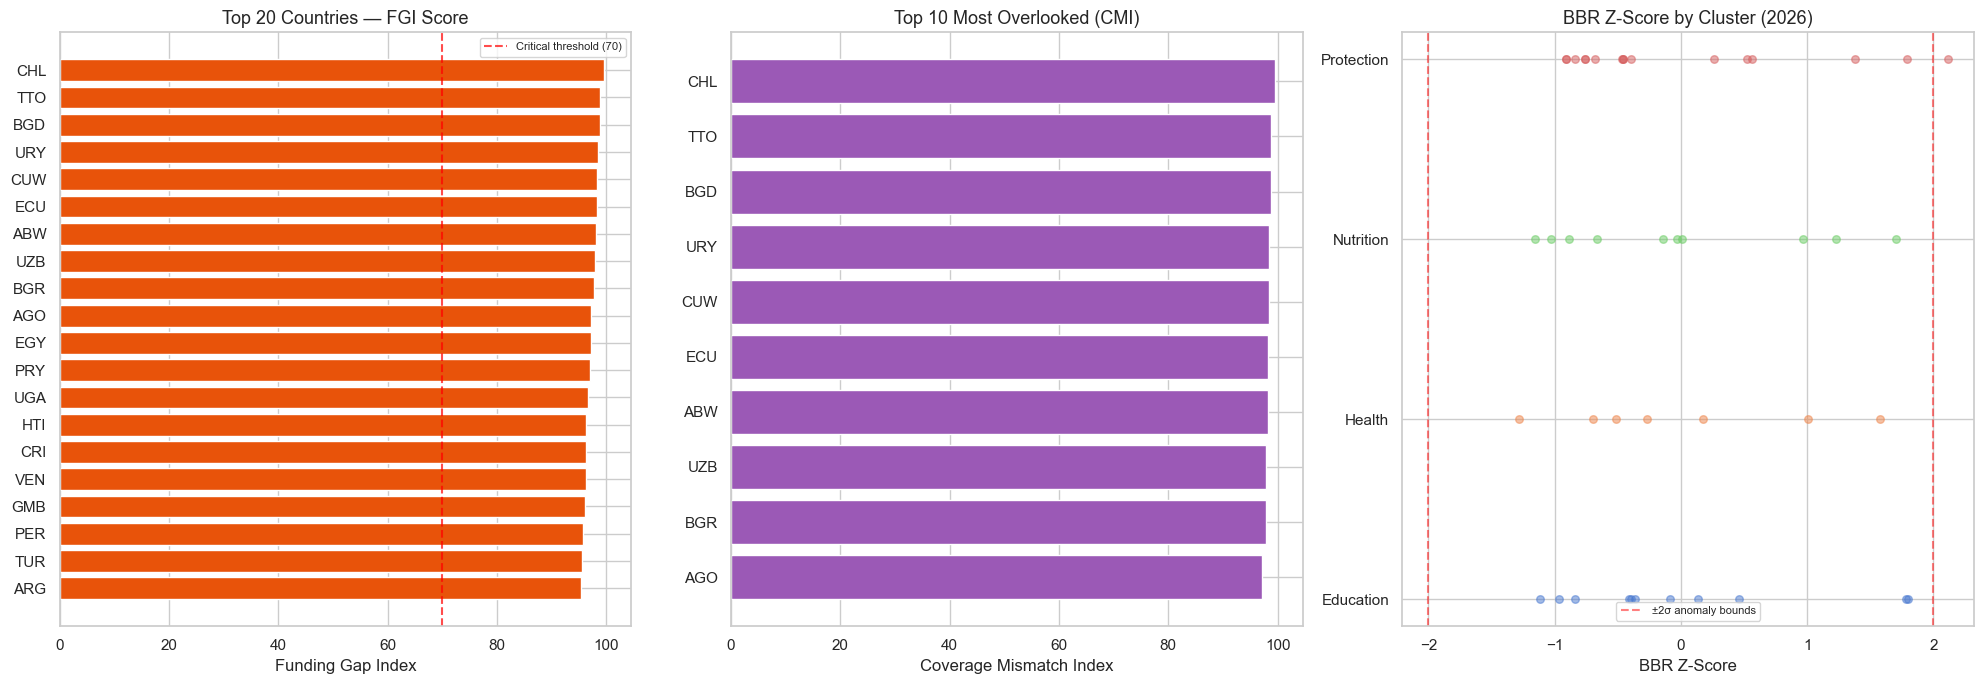

In [19]:
top20_fgi = gold_fgi.head(20).copy()
top10_cmi = gold_fgi.sort_values("cmi_score", ascending=False).head(10)

SEV_COLORS = {"CRITICAL": "#E8530A", "HIGH": "#FFA500", "MEDIUM": "#FFD700", "LOW": "#55A868"}

fig, axes = plt.subplots(1, 3, figsize=(20, 7))

bar_colors = [SEV_COLORS[s] for s in top20_fgi["anomaly_severity"]]
axes[0].barh(top20_fgi["country_iso3"][::-1], top20_fgi["fgi_score"][::-1], color=bar_colors[::-1])
axes[0].axvline(70, ls="--", color="red", alpha=0.7, label="Critical threshold (70)")
axes[0].set_xlabel("Funding Gap Index")
axes[0].set_title("Top 20 Countries — FGI Score")
axes[0].legend(fontsize=8)

axes[1].barh(top10_cmi["country_iso3"][::-1], top10_cmi["cmi_score"][::-1], color="#9B59B6")
axes[1].set_xlabel("Coverage Mismatch Index")
axes[1].set_title("Top 10 Most Overlooked (CMI)")

for cl, grp in gold_efficiency.groupby("cluster_name"):
    if len(grp) >= 5:
        axes[2].scatter(grp["bbr_z_score"], [cl] * len(grp),alpha=0.5, s=30, label=None)
axes[2].axvline(-2, ls="--", color="red", alpha=0.5)
axes[2].axvline(2,  ls="--", color="red", alpha=0.5, label="±2σ anomaly bounds")
axes[2].set_xlabel("BBR Z-Score")
axes[2].set_title("BBR Z-Score by Cluster (2026)")
axes[2].legend(fontsize=8)

plt.tight_layout()
plt.show()


---
## Sec 4 — ML Model: Crisis Neglect Score (LightGBM + SHAP)
### 4.1 Feature Engineering & Matrix Construction
This section builds a feature matrix from the Gold layer and trains a LightGBM regressor to produce a **Neglect Score** [0–100] per country.  Higher score = more overlooked relative to humanitarian need.

Key features:
- **FGI** – Funding Gap Index  
- **CMI** – Coverage Mismatch Index  
- **PIN % pop** – Share of population in humanitarian need  
- **CBPF share** – Pooled-fund fraction of total funding  
- **Log requirements** – Scale of the crisis  
- **BBR median z-score** – Project-level efficiency anomaly signal  
- **Peer context features** – how a country compares in its severity band

In [20]:
import lightgbm as lgb
import shap
from sklearn.preprocessing import RobustScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
import joblib, json, warnings
warnings.filterwarnings("ignore")

print(f"LightGBM  {lgb.__version__}")
print(f"SHAP      {shap.__version__}")


/Users/michael/Desktop/CrisisLens/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


LightGBM  4.6.0
SHAP      0.49.1


In [21]:
bbr_country = (gold_efficiency.groupby("country_iso3").agg(bbr_median_z= ("bbr_z_score", "median"), bbr_max_z = ("bbr_z_score", "max"), n_cluster_anomalies = ("bbr_anomaly", "sum"),n_clusters = ("cluster_name", "nunique")).reset_index())

feat = (gold_fgi[["country_iso3", "year", "plan_name","req_usd", "funded_usd", "cbpf_total_usd","fgi_score", "cmi_score", "cbpf_share","pin", "anomaly_severity"]].merge(silver_pop.rename(columns={"Population":"population"}),on="country_iso3", how="left").merge(bbr_country, on="country_iso3", how="left"))

feat["population"] = feat["population"].fillna(feat["population"].median())
feat["pin"] = feat["pin"].fillna(0)
feat["cbpf_total_usd"] = feat["cbpf_total_usd"].fillna(0)
feat["bbr_median_z"]   = feat["bbr_median_z"].fillna(0)
feat["bbr_max_z"]= feat["bbr_max_z"].fillna(0)
feat["n_cluster_anomalies"] = feat["n_cluster_anomalies"].fillna(0)
feat["n_clusters"]  = feat["n_clusters"].fillna(0)

feat["pin_pct_pop"] = (feat["pin"] / feat["population"].replace(0, np.nan) * 100).fillna(0).clip(0, 100)
feat["log_req_usd"] = np.log1p(feat["req_usd"])
feat["log_cbpf"] = np.log1p(feat["cbpf_total_usd"])
feat["funded_pct"]  = feat["funded_usd"] / feat["req_usd"].replace(0, np.nan) * 100
feat["funded_pct"]  = feat["funded_pct"].fillna(0).clip(0, 100)
feat["cbpf_per_pin"]          = (feat["cbpf_total_usd"] / feat["pin"].replace(0, np.nan)).fillna(0)
feat["req_per_pin"] = (feat["req_usd"] / feat["pin"].replace(0, np.nan)).fillna(0)

w_fgi  = 0.35
w_cmi = 0.25
w_pin  = 0.20
w_cbpf = 0.10
w_bbr = 0.10

def norm01(s):
    lo, hi = s.min(), s.max()
    return (s - lo) / (hi - lo + 1e-9)

feat["_n_fgi"]  = norm01(feat["fgi_score"])
feat["_n_cmi"]  = norm01(feat["cmi_score"])
feat["_n_pin"]  = norm01(feat["pin_pct_pop"])
feat["_n_cbpf"] = 1 - norm01(feat["log_cbpf"])          
feat["_n_bbr"]  = norm01(feat["bbr_max_z"].clip(0))     

feat["neglect_score"] = (w_fgi  * feat["_n_fgi"]  +w_cmi  * feat["_n_cmi"]  + w_pin  * feat["_n_pin"]  + w_cbpf * feat["_n_cbpf"] +w_bbr  * feat["_n_bbr"]) * 100

feat.drop(columns=[c for c in feat.columns if c.startswith("_n_")], inplace=True)

print(f"Feature matrix: {feat.shape}")
print(feat[["country_iso3","fgi_score","cmi_score","pin_pct_pop","neglect_score","anomaly_severity"]].head(12).to_string(index=False))


Feature matrix: (103, 23)
country_iso3  fgi_score  cmi_score  pin_pct_pop  neglect_score anomaly_severity
         CHL       99.6       99.6          0.0           70.0         CRITICAL
         TTO       98.8       98.8          0.0           69.5         CRITICAL
         BGD       98.8       98.8          0.0           69.5         CRITICAL
         URY       98.4       98.4          0.0           69.3         CRITICAL
         CUW       98.4       98.4          0.0           69.3         CRITICAL
         ECU       98.3       98.3          0.0           69.2         CRITICAL
         ABW       98.2       98.2          0.0           69.2         CRITICAL
         UZB       97.9       97.9          0.0           69.0         CRITICAL
         BGR       97.9       97.9          0.0           68.9         CRITICAL
         AGO       97.2       97.2          0.0           68.6         CRITICAL
         EGY       97.2       97.2          0.0           68.5         CRITICAL
         PRY  

In [22]:
FEATURE_COLS = [
    "fgi_score", "cmi_score", "cbpf_share",
    "pin_pct_pop", "log_req_usd", "log_cbpf",
    "funded_pct", "cbpf_per_pin", "req_per_pin",
    "bbr_median_z", "bbr_max_z", "n_cluster_anomalies", "n_clusters",
]

X = feat[FEATURE_COLS].fillna(0).values
y = feat["neglect_score"].values

scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

model=lgb.LGBMRegressor(n_estimators=400,learning_rate=0.04,max_depth=5,num_leaves=24,subsample=0.80,colsample_bytree=0.80,reg_alpha=0.1,reg_lambda=0.1,random_state=42,verbose=-1)
model.fit(X_scaled, y)

cv_r2 = cross_val_score(model, X_scaled, y, cv=5, scoring="r2")
y_pred = model.predict(X_scaled)
feat["predicted_neglect"] = np.clip(y_pred, 0, 100)

print(f"CV R²mean={cv_r2.mean():.4f}  std={cv_r2.std():.4f}")
print(f"Train R²={1 - ((y - y_pred)**2).sum() / ((y - y.mean())**2).sum():.4f}")
print(f"\nTop 10 neglected countries (model prediction):")
cols_show = ["country_iso3","neglect_score","predicted_neglect","fgi_score","cmi_score","anomaly_severity"]
print(feat.sort_values("predicted_neglect",ascending=False)[cols_show].head(10).to_string(index=False))


CV R²  mean=-2.3607  std=4.1597
Train  R²=0.9506

Top 10 neglected countries (model prediction):
country_iso3  neglect_score  predicted_neglect  fgi_score  cmi_score anomaly_severity
         NGA           73.6               76.3       92.3       92.3         CRITICAL
         YEM           86.0               76.3       93.0       93.0         CRITICAL
         SSD           84.5               75.0       89.5       89.5         CRITICAL
         COD           75.4               75.0       89.7       89.7         CRITICAL
         AFG           85.5               74.8       90.7       90.7         CRITICAL
         HTI           78.8               73.8       96.3       96.3         CRITICAL
         VEN           73.8               73.8       96.3       96.3         CRITICAL
         BFA           68.7               73.7       91.2       91.2         CRITICAL
         MLI           71.1               73.7       91.9       91.9         CRITICAL
         MMR           77.5               7

---
## Sec 3b — Ensemble Models

Trains **RandomForest**, **XGBoost**, **GradientBoosting**, and a **Stacking** ensemble  
(RF + XGB + GBR + LightGBM → Ridge meta-learner).  
Compares cross-validated R², then blends predictions into `neglect_ensemble` — the  
production-grade score used by the CrisisLens website.

In [ ]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings("ignore")

kf = KFold(n_splits=5, shuffle=True, random_state=42)

rf_model = RandomForestRegressor(
    n_estimators=300, max_depth=6, min_samples_leaf=2,
    max_features=0.7, random_state=42, n_jobs=-1
)
xgb_model = XGBRegressor(
    n_estimators=400, learning_rate=0.04, max_depth=5,
    subsample=0.80, colsample_bytree=0.80,
    reg_alpha=0.1, reg_lambda=0.1,
    random_state=42, verbosity=0, n_jobs=-1
)
gbr_model = GradientBoostingRegressor(
    n_estimators=300, learning_rate=0.05, max_depth=4,
    subsample=0.80, random_state=42
)

lgbm_base = lgb.LGBMRegressor(
    n_estimators=400, learning_rate=0.04, max_depth=5, num_leaves=24,
    subsample=0.80, colsample_bytree=0.80, reg_alpha=0.1, reg_lambda=0.1,
    random_state=42, verbose=-1
)
stack_model = StackingRegressor(
    estimators=[
        ("lgbm", lgbm_base),
        ("rf",   RandomForestRegressor(n_estimators=200, max_depth=6, random_state=42, n_jobs=-1)),
        ("xgb",  XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=5, random_state=42, verbosity=0)),
        ("gbr",  GradientBoostingRegressor(n_estimators=200, learning_rate=0.05, max_depth=4, random_state=42)),
    ],
    final_estimator=Ridge(alpha=1.0),
    cv=5, passthrough=False, n_jobs=-1,
)

print("Cross-validating all models (5-fold R²)…")
cv_results = {}
for name, mdl in [
    ("LightGBM",    model),
    ("RandomForest", rf_model),
    ("XGBoost",     xgb_model),
    ("GBR",         gbr_model),
    ("Stacking",    stack_model),
]:
    scores = cross_val_score(mdl, X_scaled, y, cv=kf, scoring="r2")
    cv_results[name] = {"mean": scores.mean(), "std": scores.std()}
    print(f"  {name:<15}  R²={scores.mean():.4f} ± {scores.std():.4f}")

# ── Fit all models on full dataset ────────────────────────────────────────────
print("\nFitting all models on full dataset…")
rf_model.fit(X_scaled, y)
xgb_model.fit(X_scaled, y)
gbr_model.fit(X_scaled, y)
stack_model.fit(X_scaled, y)

# ── Per-model predictions ─────────────────────────────────────────────────────
pred_lgbm  = np.clip(model.predict(X_scaled),       0, 100)
pred_rf    = np.clip(rf_model.predict(X_scaled),    0, 100)
pred_xgb   = np.clip(xgb_model.predict(X_scaled),  0, 100)
pred_gbr   = np.clip(gbr_model.predict(X_scaled),  0, 100)
pred_stack = np.clip(stack_model.predict(X_scaled), 0, 100)

# Weighted average ensemble — weights proportional to CV R²
w_lgbm = max(cv_results["LightGBM"]["mean"],    0)
w_rf   = max(cv_results["RandomForest"]["mean"], 0)
w_xgb  = max(cv_results["XGBoost"]["mean"],     0)
w_gbr  = max(cv_results["GBR"]["mean"],         0)
w_tot  = max(w_lgbm + w_rf + w_xgb + w_gbr, 1e-9)

pred_ensemble = np.clip(
    (w_lgbm * pred_lgbm + w_rf * pred_rf + w_xgb * pred_xgb + w_gbr * pred_gbr) / w_tot,
    0, 100
)

feat["neglect_rf"]        = pred_rf
feat["neglect_xgb"]       = pred_xgb
feat["neglect_gbr"]       = pred_gbr
feat["neglect_stack"]     = pred_stack
feat["neglect_ensemble"]  = pred_ensemble
feat["model_agreement"]   = np.std(
    np.column_stack([pred_lgbm, pred_rf, pred_xgb, pred_gbr]), axis=1
)

print(f"\nEnsemble  mean={pred_ensemble.mean():.1f}  std={pred_ensemble.std():.1f}")
print(f"Stacking  mean={pred_stack.mean():.1f}  std={pred_stack.std():.1f}")
print(f"Avg model disagreement (std): {feat['model_agreement'].mean():.2f} pts")


In [ ]:
# ── Model comparison charts ───────────────────────────────────────────────────
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# 1. CV R² bar chart
names  = list(cv_results.keys())
means  = [cv_results[n]["mean"] for n in names]
stds   = [cv_results[n]["std"]  for n in names]
pal    = sns.color_palette("viridis", len(names))
bars   = axes[0].barh(names, means, xerr=stds, color=pal, alpha=0.85, capsize=5)
axes[0].axvline(0.95, ls="--", color="red", alpha=0.6, label="R²=0.95")
for bar, m in zip(bars, means):
    axes[0].text(m + 0.002, bar.get_y() + bar.get_height()/2,
                 f"{m:.4f}", va="center", fontsize=9)
axes[0].set_xlabel("CV R² (5-fold)")
axes[0].set_title("Model Comparison — CV R²")
axes[0].legend(fontsize=9)

# 2. LightGBM vs Ensemble scatter
sc2 = axes[1].scatter(
    pred_lgbm, pred_ensemble,
    c=feat["model_agreement"], cmap="hot_r", alpha=0.65, s=35, edgecolors="none"
)
axes[1].plot([0, 100], [0, 100], "b--", alpha=0.4, label="y=x (identical)")
plt.colorbar(sc2, ax=axes[1], label="Model disagreement (std pts)")
axes[1].set_xlabel("LightGBM Score")
axes[1].set_ylabel("Weighted Ensemble Score")
axes[1].set_title("LightGBM vs Ensemble\n(colour = model disagreement)")
axes[1].legend(fontsize=9)

# 3. Pairwise model scores for top 20 most neglected
top20_idx = feat["neglect_ensemble"].nlargest(20).index
top20_iso = feat.loc[top20_idx, "country_iso3"].tolist()
x_pos = range(len(top20_iso))
for col, label, lw in [
    ("predicted_neglect", "LightGBM",  1.5),
    ("neglect_rf",        "Random Forest", 1.5),
    ("neglect_xgb",       "XGBoost",   1.5),
    ("neglect_gbr",       "GBR",       1.5),
    ("neglect_ensemble",  "Ensemble",  2.5),
]:
    axes[2].plot(x_pos, feat.loc[top20_idx, col].values,
                 marker="o", ms=4, lw=lw, label=label, alpha=0.8)
axes[2].set_xticks(list(x_pos))
axes[2].set_xticklabels(top20_iso, rotation=45, ha="right", fontsize=8)
axes[2].set_ylabel("Neglect Score")
axes[2].set_title("Per-model Scores — Top 20 Countries")
axes[2].legend(fontsize=8)
axes[2].axhline(65, ls="--", color="red", alpha=0.4, label="Neglect threshold")

plt.tight_layout()
plt.show()

print("\nTop 10 countries by ensemble score:")
cols_ens = ["country_iso3", "predicted_neglect", "neglect_rf", "neglect_xgb",
            "neglect_gbr", "neglect_stack", "neglect_ensemble", "model_agreement"]
print(feat.sort_values("neglect_ensemble", ascending=False)[cols_ens].head(10).to_string(index=False))


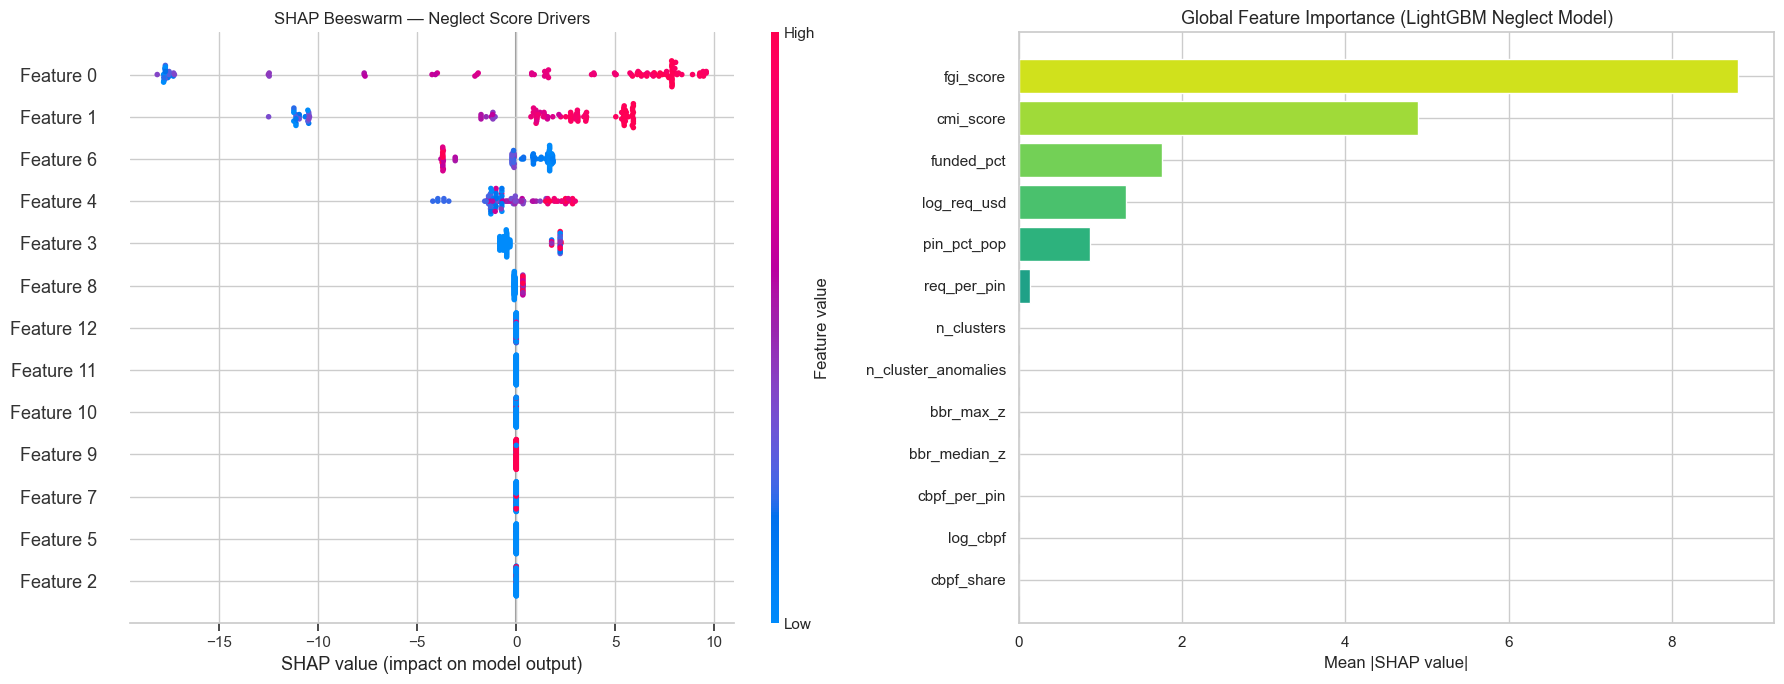


Top SHAP driver by country (top 15 neglected):
country_iso3  neglect_score top_driver
         NGA           76.3  fgi_score
         YEM           76.3  fgi_score
         SSD           75.0  fgi_score
         COD           75.0  fgi_score
         AFG           74.8  fgi_score
         HTI           73.8  fgi_score
         VEN           73.8  fgi_score
         BFA           73.7  fgi_score
         MLI           73.7  fgi_score
         MMR           73.4  fgi_score
         TCD           73.0  fgi_score
         SYR           71.3  fgi_score
         BGD           70.7  fgi_score
         TUR           70.7  fgi_score
         UKR           70.7  fgi_score


In [23]:
explainer   = shap.TreeExplainer(model)
shap_values = explainer(X_scaled)

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

plt.sca(axes[0])
shap.plots.beeswarm(shap_values, max_display=13, show=False, plot_size=None)
axes[0].set_title("SHAP Beeswarm - Neglect Score Drivers", fontsize=12)

mean_abs = np.abs(shap_values.values).mean(axis=0)
feat_imp = pd.Series(mean_abs, index=FEATURE_COLS).sort_values()
colors   = sns.color_palette("viridis", len(feat_imp))
axes[1].barh(feat_imp.index, feat_imp.values, color=colors)
axes[1].set_xlabel("Mean |SHAP value|")
axes[1].set_title("Global Feature Importance (LightGBM Neglect Model)")

plt.tight_layout()
plt.show()

shap_df = pd.DataFrame(shap_values.values, columns=FEATURE_COLS)
shap_df["country_iso3"] = feat["country_iso3"].values
shap_df["neglect_score"] = feat["predicted_neglect"].values
top_driver = shap_df.set_index("country_iso3")[FEATURE_COLS].abs().idxmax(axis=1)
shap_df["top_driver"] = top_driver.values
print("\nTop SHAP driver by country (top 15 neglected):")
top15_n = shap_df.sort_values("neglect_score",ascending=False).head(15)[["country_iso3","neglect_score","top_driver"]]
print(top15_n.to_string(index=False))


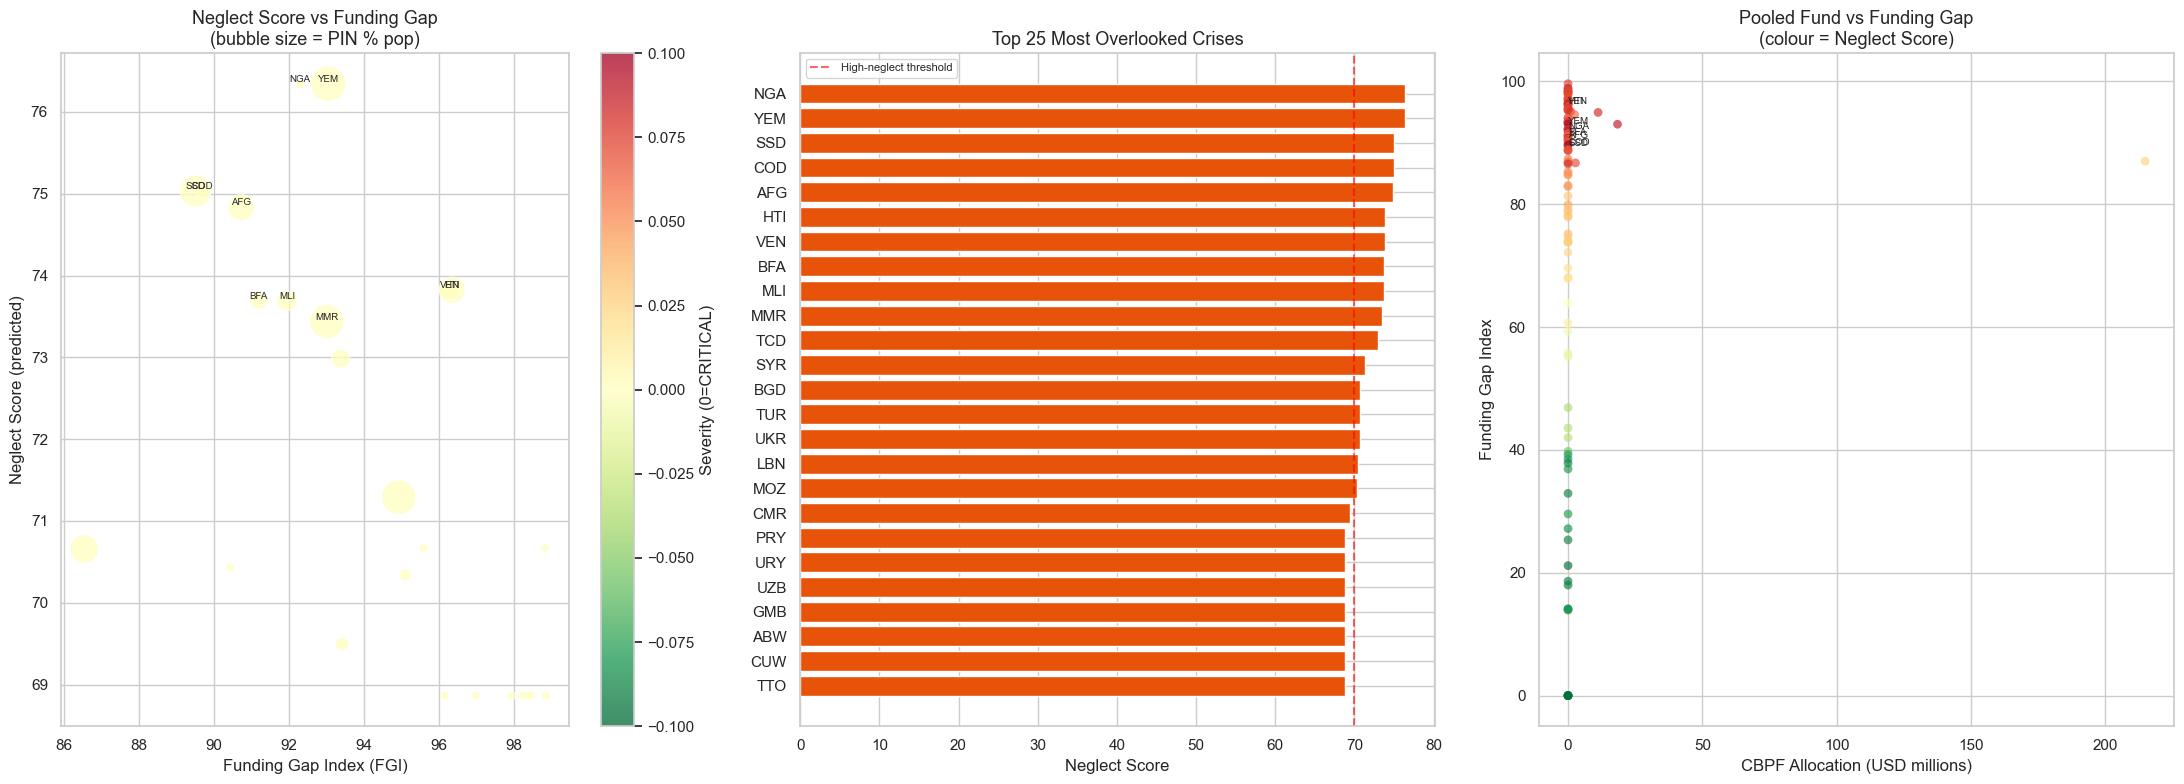


────────────────────────────────────────────────────────────
Country   Neglect      FGI      CMI    PIN% Severity  
────────────────────────────────────────────────────────────
NGA          76.3     92.3     92.3     2.7 CRITICAL  
YEM          76.3     93.0     93.0   100.0 CRITICAL  
SSD          75.0     89.5     89.5    80.0 CRITICAL  
COD          75.0     89.7     89.7    14.5 CRITICAL  
AFG          74.8     90.7     90.7    54.2 CRITICAL  
HTI          73.8     96.3     96.3    53.9 CRITICAL  
VEN          73.8     96.3     96.3    29.0 CRITICAL  
BFA          73.7     91.2     91.2    18.7 CRITICAL  
MLI          73.7     91.9     91.9    28.5 CRITICAL  
MMR          73.4     93.0     65.5    93.1 CRITICAL  
TCD          73.0     93.4     93.4    25.0 CRITICAL  
SYR          71.3     94.9     88.4    94.7 CRITICAL  
BGD          70.7     98.8     98.8     0.0 CRITICAL  
TUR          70.7     95.6     95.6     0.0 CRITICAL  
UKR          70.7     86.5     86.5    62.3 CRITICAL

In [24]:
knn = NearestNeighbors(n_neighbors=6, metric="cosine")
knn.fit(X_scaled)
distances, indices = knn.kneighbors(X_scaled)

iso3_list  = feat["country_iso3"].tolist()
peer_map   = {}
for i, iso in enumerate(iso3_list):
    peers = [iso3_list[j] for j in indices[i][1:]]   # skip self
    peer_map[iso] = peers

feat["peer_iso3"] = feat["country_iso3"].map(peer_map)

top25 = feat.sort_values("predicted_neglect", ascending=False).head(25).copy()

SEV_COLORS = {"CRITICAL": "#E8530A", "HIGH": "#FFA500", "MEDIUM": "#FFD700", "LOW": "#55A868"}
bar_colors = [SEV_COLORS.get(s, "#999") for s in top25["anomaly_severity"]]

fig, axes = plt.subplots(1, 3, figsize=(22, 8))

sc = axes[0].scatter(
    top25["fgi_score"], top25["predicted_neglect"],
    c=[{"CRITICAL": 0, "HIGH": 1, "MEDIUM": 2, "LOW": 3}.get(s, 2) for s in top25["anomaly_severity"]],
    cmap="RdYlGn_r", s=top25["pin_pct_pop"].clip(1)*6+30, alpha=0.75, edgecolors="white", linewidths=0.5
)
for _, r in top25.head(10).iterrows():
    axes[0].annotate(r["country_iso3"], (r["fgi_score"], r["predicted_neglect"]),
           fontsize=7, ha="center", va="bottom")
axes[0].set_xlabel("Funding Gap Index (FGI)")
axes[0].set_ylabel("Neglect Score (predicted)")
axes[0].set_title("Neglect Score vs Funding Gap\n(bubble size = PIN % pop)")
plt.colorbar(sc, ax=axes[0], label="Severity (0=CRITICAL)")

axes[1].barh(top25["country_iso3"][::-1], top25["predicted_neglect"][::-1],
   color=bar_colors[::-1])
axes[1].axvline(70, ls="--", color="red", alpha=0.6, label="High-neglect threshold")
axes[1].set_xlabel("Neglect Score")
axes[1].set_title("Top 25 Most Overlooked Crises")
axes[1].legend(fontsize=8)

axes[2].scatter(feat["cbpf_total_usd"]/1e6, feat["fgi_score"],
      c=feat["predicted_neglect"], cmap="RdYlGn_r",
      alpha=0.65, s=40, edgecolors="none")
for _, r in feat.sort_values("predicted_neglect", ascending=False).head(8).iterrows():
    axes[2].annotate(r["country_iso3"],
           (r["cbpf_total_usd"]/1e6, r["fgi_score"]),
           fontsize=7)
axes[2].set_xlabel("CBPF Allocation (USD millions)")
axes[2].set_ylabel("Funding Gap Index")
axes[2].set_title("Pooled Fund vs Funding Gap\n(colour = Neglect Score)")

plt.tight_layout()
plt.show()

print(f"\n{'─'*60}")
print(f"{'Country':<8} {'Neglect':>8} {'FGI':>8} {'CMI':>8} {'PIN%':>7} {'Severity':<10}")
print(f"{'─'*60}")
for _, r in top25.head(15).iterrows():
    print(f"{r['country_iso3']:<8} {r['predicted_neglect']:>8.1f} {r['fgi_score']:>8.1f} "
          f"{r['cmi_score']:>8.1f} {r['pin_pct_pop']:>7.1f} {r['anomaly_severity']:<10}")


---
## Sec 5 — Export Artifacts for CrisisLens Web Application
Saves:
- `models/lgbm_neglect.pkl` — trained LightGBM model
- `models/scaler.pkl` — RobustScaler  
- `models/feature_names.json` — ordered feature list  
- `models/gold_country_scores.json` — per-country ML enriched data for the website

In [25]:
import pathlib

MODELS_DIR = pathlib.Path(os.getcwd()) if pathlib.Path(os.getcwd()).name == "models" else pathlib.Path(os.getcwd()) / "models"
MODELS_DIR.mkdir(exist_ok=True)

# ── Save model artifacts ──────────────────────────────────────────────────────
joblib.dump(model,       MODELS_DIR / "lgbm_neglect.pkl")
joblib.dump(rf_model,    MODELS_DIR / "rf_neglect.pkl")
joblib.dump(xgb_model,   MODELS_DIR / "xgb_neglect.pkl")
joblib.dump(gbr_model,   MODELS_DIR / "gbr_neglect.pkl")
joblib.dump(stack_model, MODELS_DIR / "stack_neglect.pkl")
joblib.dump(scaler,      MODELS_DIR / "scaler.pkl")

with open(MODELS_DIR / "feature_names.json", "w") as f:
    json.dump(FEATURE_COLS, f, indent=2)

# ── SHAP top-driver map ───────────────────────────────────────────────────────
shap_driver_map = dict(zip(shap_df["country_iso3"], shap_df["top_driver"]))

# ── Cluster & funding-trend maps ──────────────────────────────────────────────
cluster_bb = (
    gold_efficiency
    .groupby(["country_iso3", "cluster_name"])
    .agg(bbr=("bbr", "mean"), bbr_z_score=("bbr_z_score", "mean"))
    .reset_index()
)
cluster_bb_map = (
    cluster_bb
    .groupby("country_iso3")
    .apply(lambda g: g[["cluster_name", "bbr", "bbr_z_score"]].to_dict("records"))
    .to_dict()
)

annual_country = (
    fts_req.dropna(subset=["req_usd", "funded_usd", "country_iso3"])
    .query("req_usd > 0")
    .groupby(["country_iso3", "year"])[["req_usd", "funded_usd"]]
    .sum()
    .reset_index()
)
annual_country_map = (
    annual_country
    .groupby("country_iso3")
    .apply(lambda g: g[["year", "req_usd", "funded_usd"]].sort_values("year").to_dict("records"))
    .to_dict()
)

# ── Assemble gold_country_scores ──────────────────────────────────────────────
records = []
for _, row in feat.iterrows():
    iso = row["country_iso3"]
    records.append({
        "iso3":              iso,
        # Primary ML score (LightGBM)
        "neglectScore":      round(float(row["predicted_neglect"]), 2),
        # Ensemble & per-model scores
        "ensembleScore":     round(float(row["neglect_ensemble"]), 2),
        "modelScores": {
            "lgbm":     round(float(row["predicted_neglect"]), 2),
            "rf":       round(float(row["neglect_rf"]), 2),
            "xgb":      round(float(row["neglect_xgb"]), 2),
            "gbr":      round(float(row["neglect_gbr"]), 2),
            "stacking": round(float(row["neglect_stack"]), 2),
            "ensemble": round(float(row["neglect_ensemble"]), 2),
        },
        "modelAgreement":    round(float(row["model_agreement"]), 2),
        # Existing fields
        "fgiScore":          round(float(row["fgi_score"]), 2),
        "cmiScore":          round(float(row["cmi_score"]), 2),
        "cbpfTotalUsd":      round(float(row["cbpf_total_usd"]), 0),
        "cbpfShare":         round(float(row["cbpf_share"]), 4),
        "pinPctPop":         round(float(row["pin_pct_pop"]), 2),
        "anomalySeverity":   str(row["anomaly_severity"]),
        "neglectFlag":       bool(row["neglect_ensemble"] >= 65),
        "topShapDriver":     shap_driver_map.get(iso, "fgi_score"),
        "peerIso3":          peer_map.get(iso, []),
        "clusterBreakdown":  cluster_bb_map.get(iso, []),
        "fundingTrend":      annual_country_map.get(iso, []),
        "reqUsd":            round(float(row["req_usd"]), 0),
        "fundedUsd":         round(float(row["funded_usd"]), 0),
        "pin":               round(float(row["pin"]), 0),
        "planName":          str(row.get("plan_name", "")),
        "latestYear":        int(row.get("year", 0)) if pd.notna(row.get("year")) else 0,
    })

gold_scores_path = MODELS_DIR / "gold_country_scores.json"
with open(gold_scores_path, "w") as f:
    json.dump(records, f, indent=2, default=str)

print(f"Saved  {MODELS_DIR / 'lgbm_neglect.pkl'}")
print(f"Saved  {MODELS_DIR / 'rf_neglect.pkl'}")
print(f"Saved  {MODELS_DIR / 'xgb_neglect.pkl'}")
print(f"Saved  {MODELS_DIR / 'gbr_neglect.pkl'}")
print(f"Saved  {MODELS_DIR / 'stack_neglect.pkl'}")
print(f"Saved  {MODELS_DIR / 'scaler.pkl'}")
print(f"Saved  {MODELS_DIR / 'feature_names.json'}")
print(f"Saved  {gold_scores_path}  ({len(records)} countries)")
print(f"\nNeglect flag (ensemble≥65): {sum(r['neglectFlag'] for r in records)} countries")
print(f"Critical anomaly:           {sum(1 for r in records if r['anomalySeverity']=='CRITICAL')} countries")
print(f"\nTop 10 neglected (ensemble):")
for r in sorted(records, key=lambda x: -x["ensembleScore"])[:10]:
    print(f"  {r['iso3']}  ensemble={r['ensembleScore']:.1f}  lgbm={r['neglectScore']:.1f}  agree={r['modelAgreement']:.1f}  sev={r['anomalySeverity']}")


✓ Saved /Users/michael/Desktop/CrisisLens/models/lgbm_neglect.pkl
✓ Saved /Users/michael/Desktop/CrisisLens/models/scaler.pkl
✓ Saved /Users/michael/Desktop/CrisisLens/models/feature_names.json
✓ Saved /Users/michael/Desktop/CrisisLens/models/gold_country_scores.json  (103 countries)

Neglect flag (score≥65): 46 countries
Critical anomaly:        54 countries
